# Chargement des Bibliothèques et Fonctions Auxiliaires

## Charger des packages Python

In [ ]:
!pip install rpy2  -qq

In [ ]:
!apt-get install r-base -qq

In [ ]:
!pip install keras>=3.2.0  -qq

In [ ]:
%load_ext rpy2.ipython

In [ ]:
import numpy as np
import pandas as pd
import random
np.random.seed(1)
random.seed(42)


import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
import tensorflow as tf
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri

from google.colab import drive #pour travailler sur colab
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Maestria_Sorbonne/M2/2 s2/2 Reseaux Neuronaux/Project'
path_graphs = path + '/graphs'

Mounted at /content/drive


## Charger des packages R

In [ ]:
%%R
.libPaths("/content/drive/MyDrive/Maestria_Sorbonne/M2/2 s2/2 Reseaux Neuronaux/Project/packages")
options(warn = -1)
library(MASS)
library(ggplot2)
library(e1071)
library(rsample)
library(caret)
library(lattice)
library(nnet)
library(NeuralNetTools)
library(patchwork)
library(RColorBrewer)
library(kohonen)
library(dplyr)
options(warn = 0)

Attaching package: ‘rsample’



    permutations



Attaching package: ‘patchwork’



    area


Attaching package: ‘dplyr’



    select



    filter, lag



    intersect, setdiff, setequal, union




## Fonctions

### En R

In [ ]:
%%R
rm(list = ls())

diviser_donnees <- function(corpus, prop_split = 0.7) {
  corpus <- corpus[sample(nrow(corpus)), ]
  corpus$d <- factor(corpus$d)

  split <- initial_split(corpus, prop = prop_split)
  train_data <- training(split)
  test_data <- testing(split)
  test_data_visual <- test_data

  return(list(train_data = train_data,
              test_data = test_data
              ))
}



accuracy <- function(target, pred) {
  precision <- sum(target == pred) / length(target)
  return(round(precision, 3))
}


In [ ]:
%%R
objects = ls()
rm(list = setdiff(ls(), objects))

### En Python

In [ ]:
figsize_ =(8, 6)
colors_ = ["#9D00FF","#FFA600","#4EE2EC"]
color_base = '#7A003D'
colors = ["red", "#19c548"]

def graphique_dispersion(donnees
                         , X2
                         , X1
                         , d
                         ,axes
                         , titre="Graphique en Dispersion"):
    sns.scatterplot(x=X2
                    ,y=X1
                    ,hue=d
                    , data=donnees
                    , alpha=0.5
                    , s=20
                    , palette=colors_
                    , ax=axes)

    axes.set_title(titre)
    axes.set_xlabel("X2")
    axes.set_ylabel("X1")

    axes.set_aspect('equal', adjustable='box')
    axes.grid(False)
    axes.legend(title="Catégories"
                , loc='upper right'
                , fontsize=8
                , title_fontsize=10)


def graphique_bien_mal(donnees
                       , X2
                       , X1
                       , bien
                       , axes
                       ,titre="Graphique en Dispersion"):

    sns.scatterplot(x=X2
                    , y=X1
                    , hue=bien
                    , data=donnees
                    , alpha=0.5
                    , s=20
                    ,palette=colors
                    , ax=axes)

    axes.set_title(titre)
    axes.set_xlabel("x2")
    axes.set_ylabel("x1")

    axes.set_aspect('equal', adjustable='box')
    axes.grid(False)
    axes.legend(title="Classification"
                    , loc="upper right"
                    , fontsize=8
                    , title_fontsize=10)


def tracer_matrice_confusion(reel, pred, axes):
    cm = confusion_matrix(np.array(reel, dtype=int), np.array(pred, dtype=int))
    sns.heatmap(cm, annot=True, fmt='g', cmap='PuRd'
                , cbar_kws={'label': 'Fréquence'}
                , ax=axes
                , annot_kws={"size": 15})
    axes.set_title('Matrice de Confusion')
    axes.set_xlabel('Prédictions')
    axes.set_ylabel('Réelles')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    axes.set_yticklabels(axes.get_yticklabels(), rotation=45, va='top')
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.set_aspect('auto')
    axes.grid(False)

def afficher_graphiques(donnees, X2, X1, d , pred, bien, modele,echantillon):
    fig, axes = plt.subplots(1, 4, figsize=(26, 5))
    precision = donnees[bien].astype(float).mean()

    graphique_dispersion(donnees, X2, X1, d, axes[0], titre="Réel")
    graphique_dispersion(donnees, X2, X1, pred, axes[1], titre="Prédiction")
    graphique_bien_mal(donnees, X2, X1, bien, axes[2], titre="Bien vs Mal")
    tracer_matrice_confusion(donnees[d], donnees[pred], axes[3])

    fig.suptitle(
        f"Modèle {modele} sur l'ensemble de test avec une précision de : "
        f"{round(precision, 5)}",
        fontsize=18,
        y=1.05
              )

    fichier_sortie = f"{path_graphs}/{echantillon}_{modele}.png"
    plt.savefig(fichier_sortie, format="png", bbox_inches="tight")

    plt.show()


# Point 2


In [ ]:
results= {} #Dictionnaire de résultats

## GAUSS

### Echantillongage

In [ ]:
echantillon = "GAUSS"

In [ ]:
%%R
generate_bivariate_data <- function(n, mean_vector, cov_matrix, d) {
  data <- mvrnorm(n = n, mu = mean_vector, Sigma = cov_matrix)
  data <- as.data.frame(data)
  data$d <- d
  colnames(data) <- c("X1", "X2", "d")
  return(data)
}

n = 1000

m1 <- c(0, 2)
c1 <- matrix(c(10, -0.5, -0.5, 10), nrow = 2)

sample1 <- generate_bivariate_data(n, m1, c1, 0)

m2 <- c(0, 15)
c2 <- matrix(c(20, -0.9, -0.9, 20), nrow = 2)
sample2 <- generate_bivariate_data(n, m2, c2, 1)

m3 <- c(12, 8)
c3 <- matrix(c(5, -0.1, -0.1, 5), nrow = 2)
sample3 <- generate_bivariate_data(n, m3, c3, 2)

# corpus
corpus <- rbind(sample1, sample2, sample3)

sets <- diviser_donnees(corpus, prop_split = 0.7)

train_data_GAUSS <- sets$train_data
test_data_GAUSS <- sets$test_data

### Models

#### SVM

##### Implementation

In [ ]:
%%R
set.seed(1)
model_SVM <- svm(d ~ X1 + X2
                 ,data = sets$train_data
                 ,type = 'C-classification'
                 ,kernel = "linear"
                 )
summary(model_SVM)


Call:
svm(formula = d ~ X1 + X2, data = sets$train_data, type = "C-classification", 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  284

 ( 98 119 67 )


Number of Classes:  3 

Levels: 
 0 1 2





##### Prediction

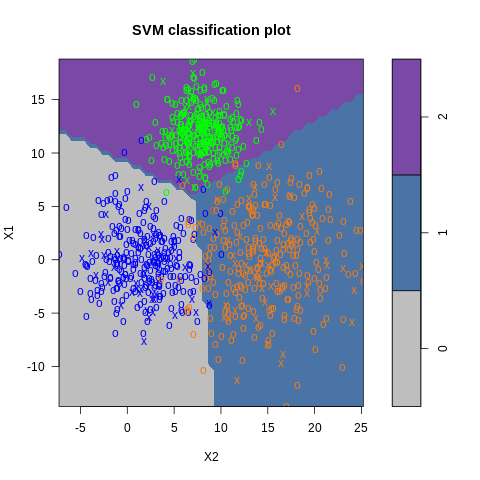

In [ ]:
%%R
set.seed(1)
pred <- predict(model_SVM, sets$test_data)

plot(model_SVM, sets$test_data,
     col = c("grey", "#4974a5", "#7a49a5"),
     symbolPalette = c("blue", "#f07b18", "green"),
     cex = 0.2)

Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)
train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$bien <- test_data_$d == test_data_$pred


In [ ]:
pandas2ri.activate()

train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'SVM'
results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

#### PMC

##### Implementation

In [ ]:
%%R
set.seed(1)

tune.grid_nnet <- expand.grid(size = c(1, 3, 5),
                              decay = c(0.2,0.1, 0.001, 0.000001))

model <- train(d ~ . ,
               data = sets$train_data,
               method = "nnet",
               tuneGrid = tune.grid_nnet,
               trControl = trainControl(method = "cv", number = 10),
               linout = FALSE,
               trace = FALSE)

best_params <- model$bestTune

model_PMC = nnet(d ~ .
                 , data = sets$train_data
                 , size = best_params$size
                 , decay = best_params$decay
                 , linout = FALSE
                 )
summary(model_PMC)

# weights:  33
initial  value 2508.579978 
iter  10 value 951.877971
iter  20 value 488.096749
iter  30 value 369.696613
iter  40 value 307.167229
iter  50 value 295.018360
iter  60 value 292.238606
iter  70 value 290.637711
iter  80 value 289.280003
iter  90 value 289.087338
iter 100 value 288.821858
final  value 288.821858 
stopped after 100 iterations
a 2-5-3 network with 33 weights
options were - softmax modelling  decay=0.2
 b->h1 i1->h1 i2->h1 
 -3.68  -0.17   0.38 
 b->h2 i1->h2 i2->h2 
 -3.04   0.53  -0.05 
 b->h3 i1->h3 i2->h3 
 -1.07  -0.87   0.71 
 b->h4 i1->h4 i2->h4 
  3.63  -0.35  -0.31 
 b->h5 i1->h5 i2->h5 
  2.25  -0.04  -0.63 
 b->o1 h1->o1 h2->o1 h3->o1 h4->o1 h5->o1 
 -0.22  -2.79  -3.10   0.88   3.07   2.97 
 b->o2 h1->o2 h2->o2 h3->o2 h4->o2 h5->o2 
 -0.49   4.16  -0.43   1.48  -0.07  -1.00 
 b->o3 h1->o3 h2->o3 h3->o3 h4->o3 h5->o3 
  0.71  -1.37   3.53  -2.36  -2.99  -1.97 


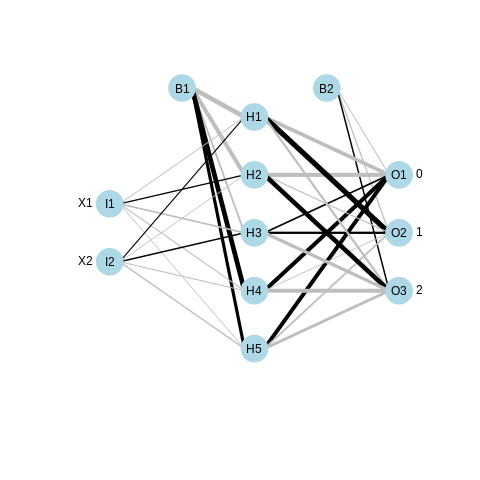

In [ ]:
%%R
plotnet(model_PMC)

##### Predicition

In [ ]:
%%R
set.seed(1)
pred_ <- predict(model_PMC, sets$test_data)
pred <- apply(pred_, 1, which.max) -1


Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)

train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$bien <- test_data_$d == test_data_$pred


In [ ]:
pandas2ri.activate()
train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'PMC'

results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

### Results

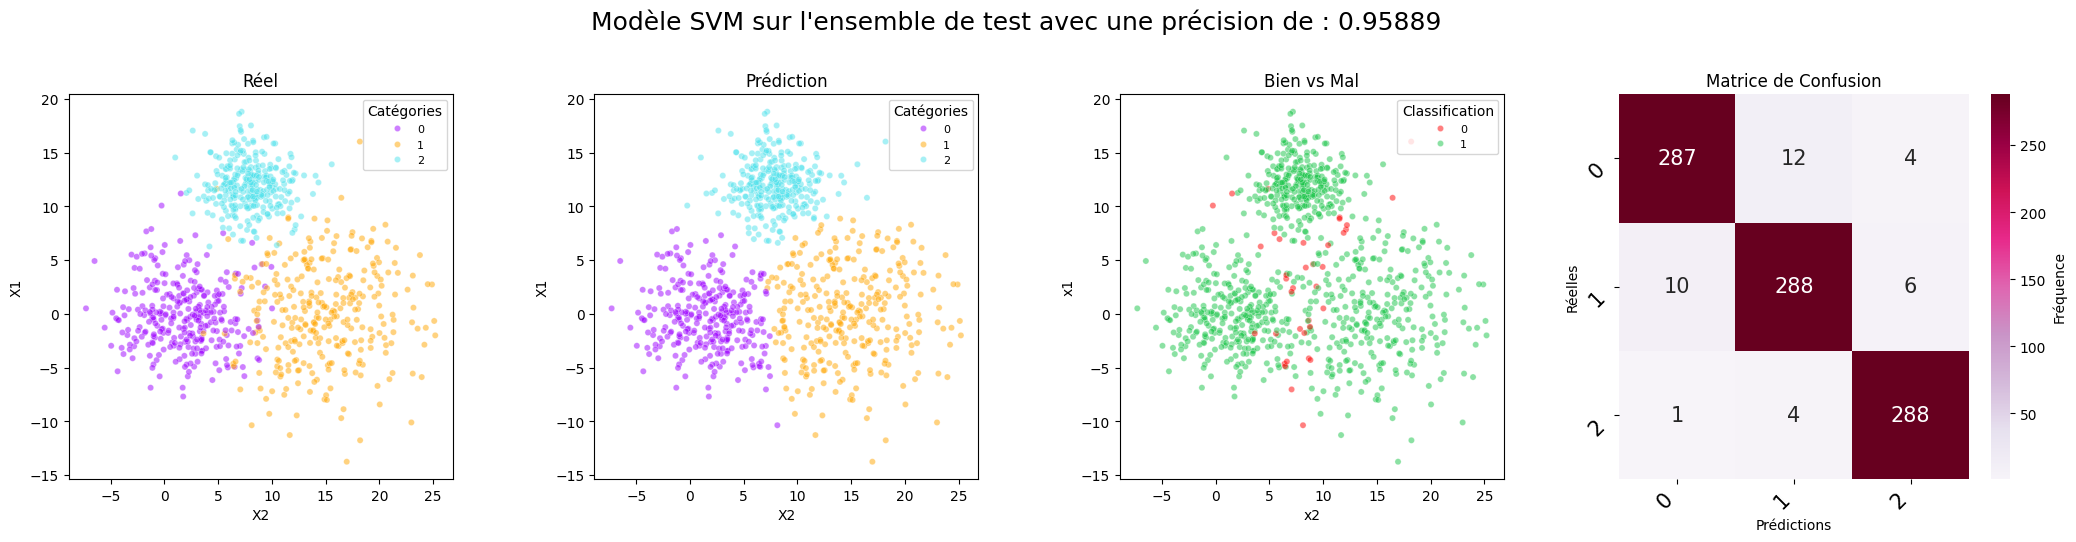

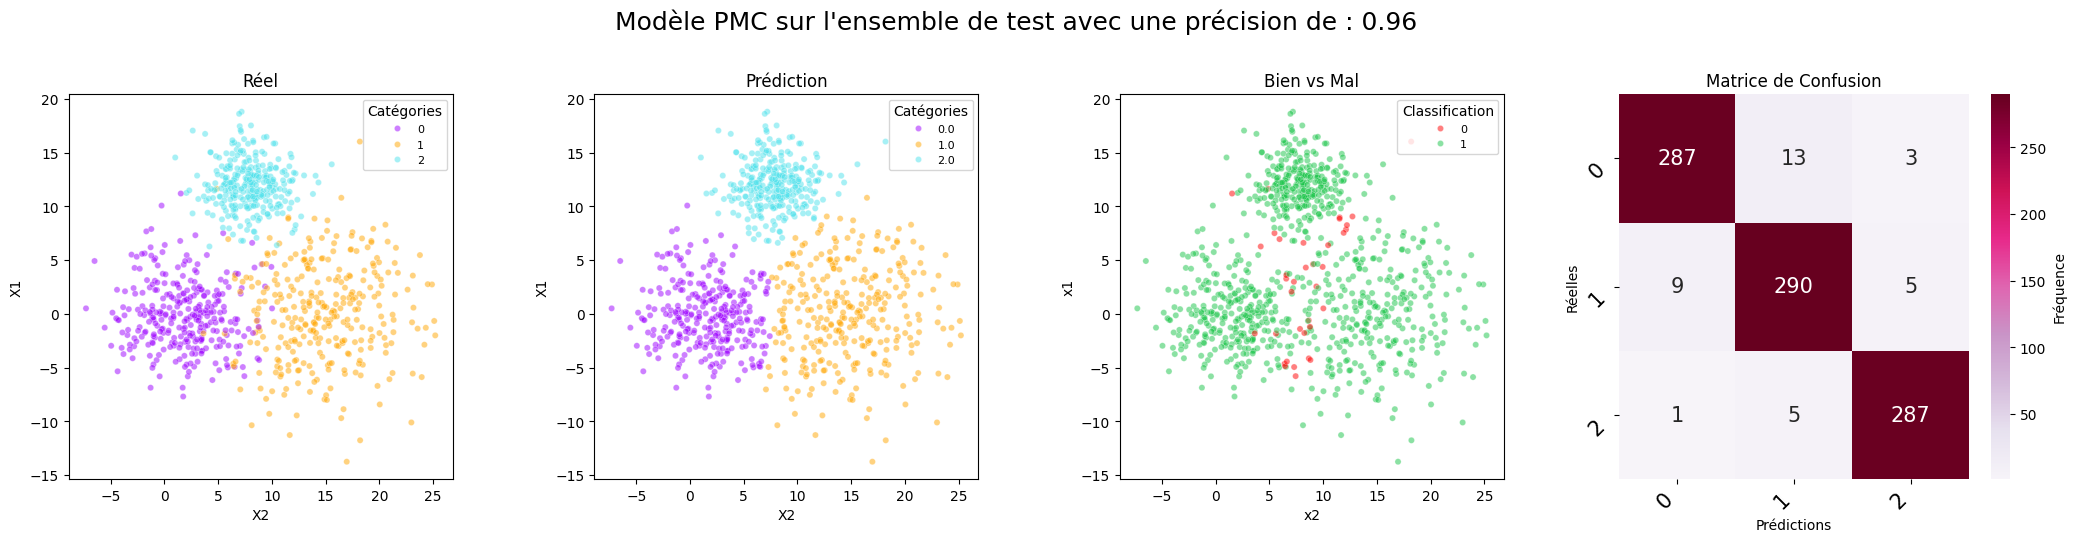

In [ ]:
afficher_graphiques(results[(echantillon,'SVM')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'SVM'
                    ,echantillon)


afficher_graphiques(results[(echantillon,'PMC')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'PMC'
                    ,echantillon)

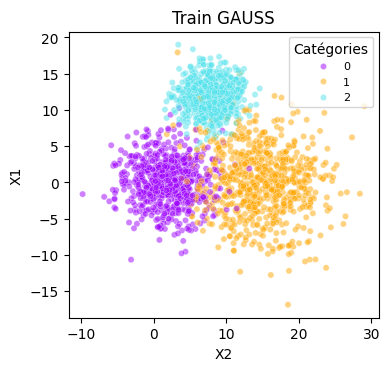

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
graphique_dispersion(results[(echantillon,'SVM')]['train_data']
                     , 'X2'
                     , 'X1'
                     , 'd'
                     , ax
                     , titre=f'Train {echantillon}')
fichier_sortie = f"{path_graphs}/{echantillon}_train.png"
plt.savefig(fichier_sortie, format="png", bbox_inches="tight")
plt.show()

## CARRE

### Echantillongage

In [ ]:
echantillon = "CARRE"


In [ ]:
%%R
set.seed(100)

generate_square_data <- function(x_min, x_max, y_min, y_max, n_points, label) {
  x <- runif(n_points, x_min, x_max)
  y <- runif(n_points, y_min, y_max)
  data <- data.frame(X = x, Y = y, d = label)
  colnames(data) <- c("X1", "X2", "d")
  return(data)
}

n_points <- 300

square1 <- generate_square_data(0, 1, 0, 1, n_points, 0)
square2 <- generate_square_data(1, 2, 0, 1, n_points, 1)
square3 <- generate_square_data(2, 3, 0, 1, n_points, 2)

square4 <- generate_square_data(1, 2, 1, 2, n_points, 0)
square5 <- generate_square_data(2, 3, 1, 2, n_points, 1)
square6 <- generate_square_data(0, 1, 1, 2, n_points, 2)

square7 <- generate_square_data(2, 3, 2, 3, n_points, 0)
square8 <- generate_square_data(0, 1, 2, 3, n_points, 1)
square9 <- generate_square_data(1, 2, 2, 3, n_points, 2)

corpus <- rbind(square1, square2, square3,
              square4, square5, square6,
              square7, square8, square9
              )

sets <- diviser_donnees( corpus, prop_split = 0.7)

train_data_CARRE <- sets$train_data
test_data_CARRE <- sets$test_data

### Models

#### SVM

##### Implementation

In [ ]:
%%R
set.seed(1)
model_SVM <- svm(d ~ X1 + X2
                 ,data = sets$train_data
                 ,type = 'C-classification'
                 ,kernel = "linear"
                 )


summary(model_SVM)



Call:
svm(formula = d ~ X1 + X2, data = sets$train_data, type = "C-classification", 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  1880

 ( 626 634 620 )


Number of Classes:  3 

Levels: 
 0 1 2





##### Prediction

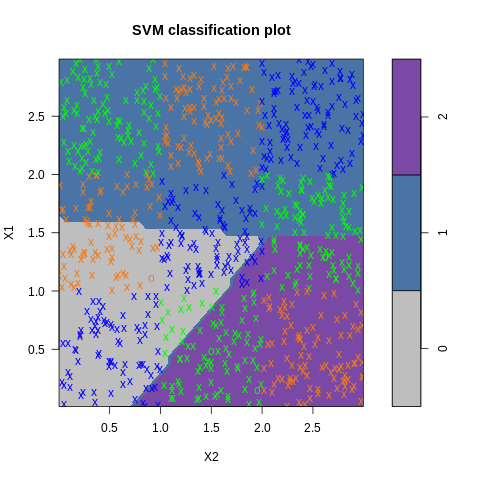

In [ ]:
%%R
set.seed(41)
pred <- predict(model_SVM, sets$test_data)

plot(model_SVM, sets$test_data,
     col = c("grey", "#4974a5", "#7a49a5"),
     symbolPalette = c("blue", "#f07b18", "green"),
     cex = 0.2)

Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)
train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$bien <- test_data_$d == test_data_$pred


In [ ]:
pandas2ri.activate()

train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'SVM'
results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

#### PMC

##### Implementation

In [ ]:
%%R
set.seed(1)

tune.grid_nnet <- expand.grid(size = c(6,10,14),
                              decay = c(0.1, 0.001, 0.000001))

model <- train(d ~ . ,
               data = sets$train_data,
               method = "nnet",
               tuneGrid = tune.grid_nnet,
               trControl = trainControl(method = "cv", number = 10),
               linout = FALSE,
               trace = FALSE)

best_params <- model$bestTune

model_PMC = nnet(d ~ .
                 , data = sets$train_data
                 , size = best_params$size
                 , decay = best_params$decay
                 , linout = FALSE
                 )
summary(model_PMC)

# weights:  87
initial  value 2728.245518 
iter  10 value 1429.351931
iter  20 value 1133.942540
iter  30 value 919.156218
iter  40 value 792.621866
iter  50 value 721.754037
iter  60 value 695.520522
iter  70 value 652.406066
iter  80 value 586.723899
iter  90 value 533.013283
iter 100 value 487.819646
final  value 487.819646 
stopped after 100 iterations
a 2-14-3 network with 87 weights
options were - softmax modelling  decay=0.1
 b->h1 i1->h1 i2->h1 
  3.70  -2.23  -4.13 
 b->h2 i1->h2 i2->h2 
  0.25   0.90  -0.73 
 b->h3 i1->h3 i2->h3 
 10.54  -4.91  -2.17 
 b->h4 i1->h4 i2->h4 
  3.58  -2.81  -1.95 
 b->h5 i1->h5 i2->h5 
-11.34   4.85   4.53 
 b->h6 i1->h6 i2->h6 
  2.10  -2.72   5.24 
 b->h7 i1->h7 i2->h7 
  1.33   5.39  -3.36 
 b->h8 i1->h8 i2->h8 
-12.35   2.52   5.29 
 b->h9 i1->h9 i2->h9 
 -6.48   3.61   5.07 
 b->h10 i1->h10 i2->h10 
   5.16   -0.86   -1.69 
 b->h11 i1->h11 i2->h11 
   1.54   -7.10    6.03 
 b->h12 i1->h12 i2->h12 
  -1.39    3.63   -5.19 
 b->h13 i1->h13 i2

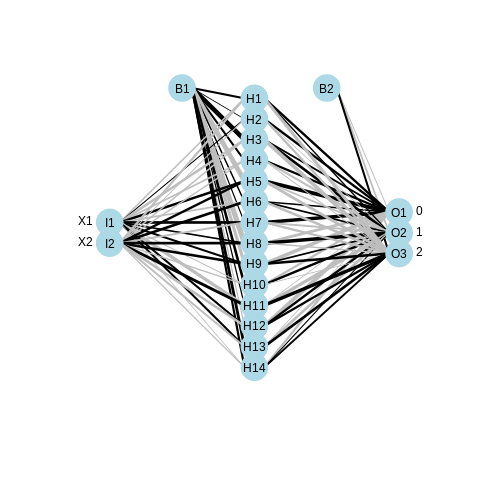

In [ ]:
%%R
plotnet(model_PMC)

##### Predicition

In [ ]:
%%R
set.seed(1)
pred_ <- predict(model_PMC, sets$test_data)
pred <- apply(pred_, 1, which.max) -1


Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)

train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$bien <- test_data_$d == test_data_$pred

In [ ]:
pandas2ri.activate()
train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'PMC'

results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

### Results

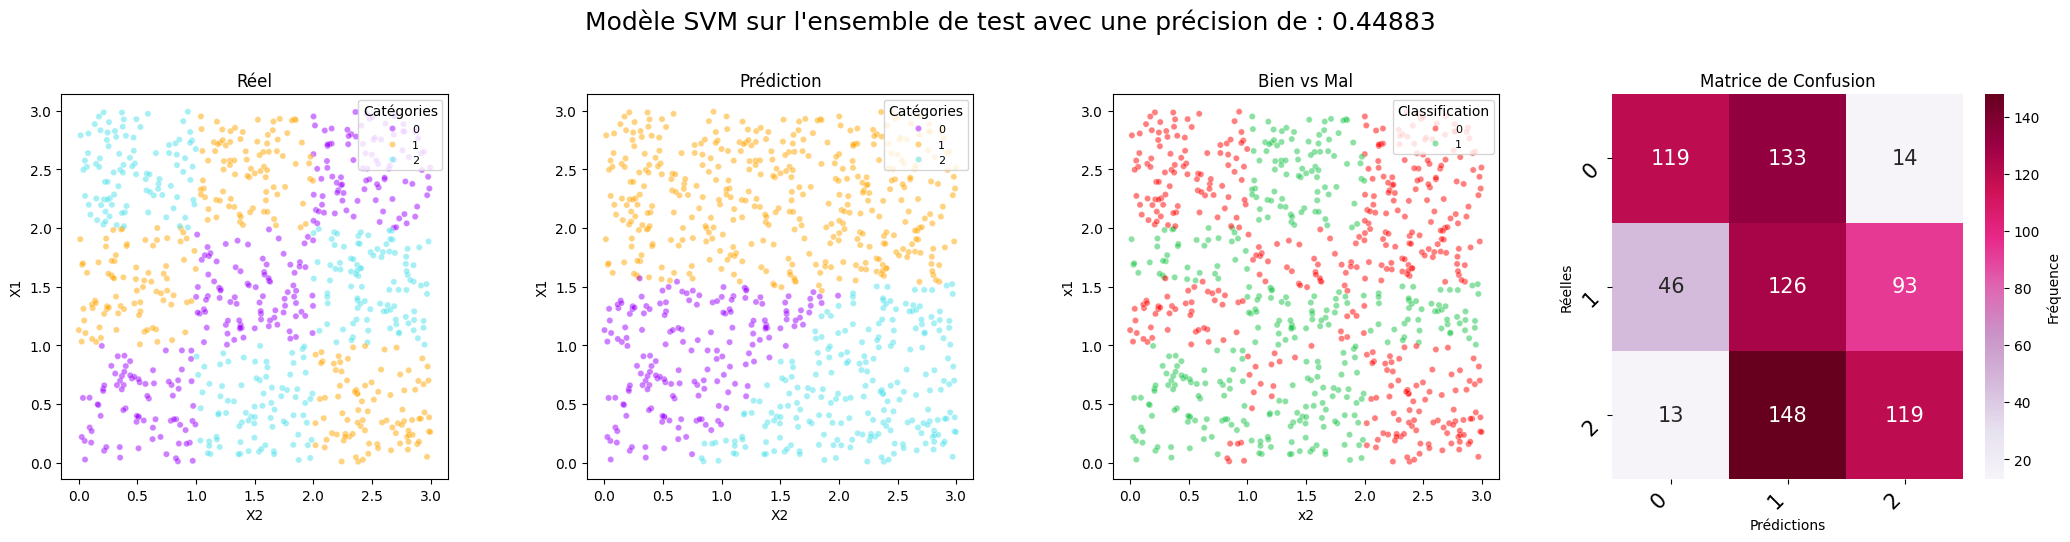

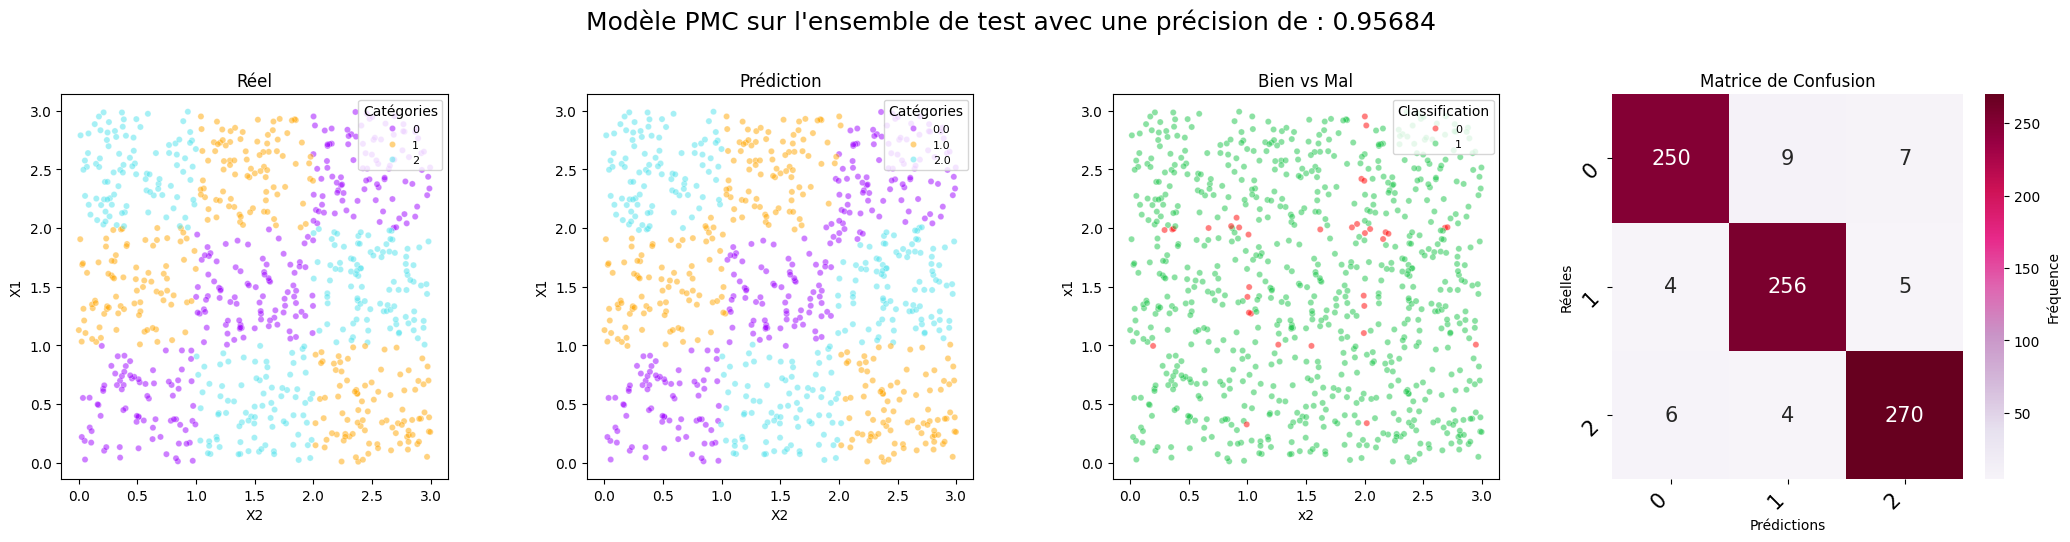

In [ ]:
afficher_graphiques(results[(echantillon,'SVM')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'SVM'
                    ,echantillon)


afficher_graphiques(results[(echantillon,'PMC')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'PMC'
                    ,echantillon)

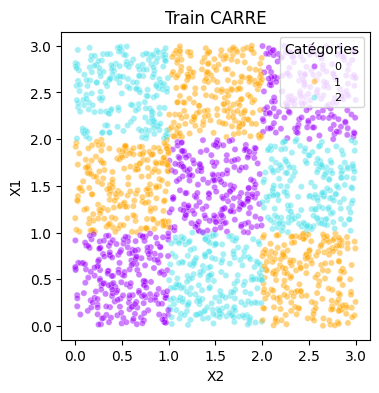

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
graphique_dispersion(results[(echantillon,'SVM')]['train_data']
                     , 'X2'
                     , 'X1'
                     , 'd'
                     ,ax
                     , titre=f'Train {echantillon}')


fichier_sortie = f"{path_graphs}/{echantillon}_train.png"
plt.savefig(fichier_sortie, format="png", bbox_inches="tight")
plt.show()

# Point 3

## SPIRALE

### Echantillongage

In [ ]:
echantillon = "SPIRALE"

In [ ]:
%%R

set.seed(1)

generate_spiral_data <- function(n , a, d) {
  t <- seq(0, 4*pi, length.out = n)
  data <- data.frame(X1 = t * cos(t + a), X2 = t * sin(t+a))
  data$d <- d
  return(data)
}

n <- 2000

sample1 <- generate_spiral_data(n, 0, 0)
sample2 <- generate_spiral_data(n, pi, 1)

# corpus
corpus <- rbind(sample1, sample2)

sets <- diviser_donnees(corpus, prop_split = 0.7)

train_data_SPIRALE <- sets$train_data
test_data_SPIRALE <- sets$test_data

### Models

#### SVM

##### Implementation

In [ ]:
%%R
set.seed(1)
model_SVM <- svm(d ~ X1 + X2
                 ,data = sets$train_data
                 ,type = 'C-classification'
                 ,kernel = "linear"
                 )


summary(model_SVM)



Call:
svm(formula = d ~ X1 + X2, data = sets$train_data, type = "C-classification", 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  2536

 ( 1268 1268 )


Number of Classes:  2 

Levels: 
 0 1





##### Prediction

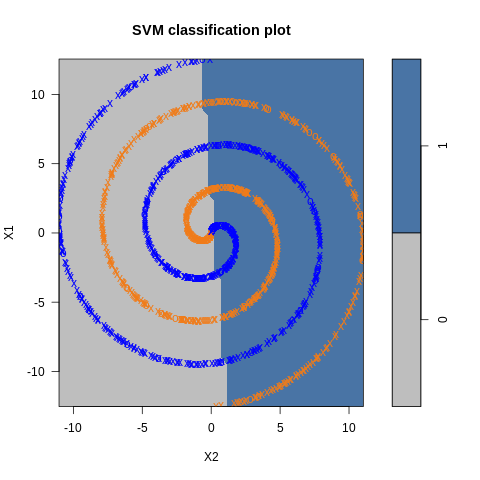

In [ ]:
%%R
set.seed(1)
pred <- predict(model_SVM, sets$test_data)

plot(model_SVM, sets$test_data,
     col = c("grey", "#4974a5", "#7a49a5"),
     symbolPalette = c("blue", "#f07b18", "green"),
     cex = 0.2)

Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)
train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$bien <- test_data_$d == test_data_$pred


In [ ]:
pandas2ri.activate()

train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'SVM'
results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

#### PMC

##### Implementation

In [ ]:
%%R
set.seed(1)

tune.grid_nnet <- expand.grid(size = c(10,15,20),
                              decay = c(0.1, 0.001, 0.000001))

model <- train(d ~ . ,
               data = sets$train_data,
               method = "nnet",
               tuneGrid = tune.grid_nnet,
               trControl = trainControl(method = "cv", number = 10),
               linout = FALSE,
               trace = FALSE)

best_params <- model$bestTune

model_PMC = nnet(d ~ .
                 , data = sets$train_data
                 , size = best_params$size
                 , decay = best_params$decay
                 , linout = FALSE
                 )
summary(model_PMC)

# weights:  81
initial  value 2157.763557 
iter  10 value 1791.846489
iter  20 value 1677.316341
iter  30 value 1598.509928
iter  40 value 1532.770651
iter  50 value 1493.553360
iter  60 value 1459.201968
iter  70 value 1439.568491
iter  80 value 1420.714634
iter  90 value 1391.604437
iter 100 value 1340.188623
final  value 1340.188623 
stopped after 100 iterations
a 2-20-1 network with 81 weights
options were - entropy fitting  decay=1e-06
 b->h1 i1->h1 i2->h1 
 -0.71   0.42  -0.62 
 b->h2 i1->h2 i2->h2 
  7.47   1.19  -0.51 
 b->h3 i1->h3 i2->h3 
 -0.12  -0.07   0.83 
 b->h4 i1->h4 i2->h4 
  3.16  -0.58   0.47 
 b->h5 i1->h5 i2->h5 
 -3.21  -9.51  -0.31 
 b->h6 i1->h6 i2->h6 
  5.81 -22.62  17.73 
 b->h7 i1->h7 i2->h7 
-22.69   4.90   9.39 
 b->h8 i1->h8 i2->h8 
 -1.33  -3.33  -0.17 
 b->h9 i1->h9 i2->h9 
 -0.70  18.38  13.43 
 b->h10 i1->h10 i2->h10 
   3.20    1.09   -1.85 
 b->h11 i1->h11 i2->h11 
   0.61    0.95   -1.51 
 b->h12 i1->h12 i2->h12 
   0.19    2.36  -26.33 
 b->h13 i

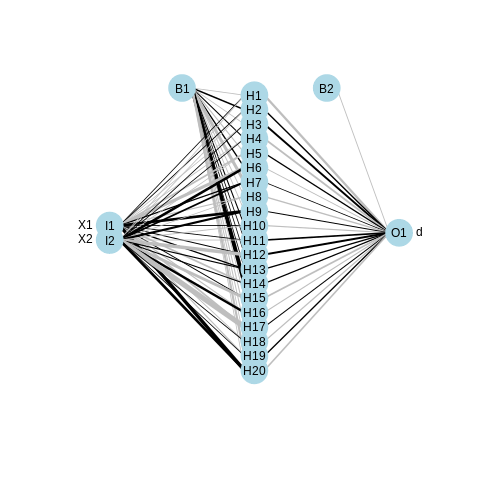

In [ ]:
%%R
plotnet(model_PMC)

##### Predicition

In [ ]:
%%R
set.seed(1)
pred_ <- predict(model_PMC, sets$test_data)
pred <-  ifelse(pred_ > 0.5, 1, 0)

Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
%%R
rm(train_data_, test_data_)

train_data_ <- sets$train_data
test_data_ <- sets$test_data
test_data_$pred <- pred
test_data_$pred <- as.vector(test_data_$pred)

test_data_$bien <- test_data_$d == test_data_$pred
test_data_$bien <- test_data_$bien


In [ ]:
pandas2ri.activate()
train_data = ro.r["train_data_"]
test_data = ro.r["test_data_"]

test_data['bien'] = test_data['bien'].astype('category')

modele = 'PMC'

results[(echantillon, modele)] = {
    "train_data": train_data,
    "test_data": test_data
    }

#### KERAS

##### Implementation

In [ ]:
pandas2ri.activate()

# y

y_train_ = results[(echantillon,'PMC')]['train_data']['d']
y_train = to_categorical(y_train_, num_classes=2)

y_test_ = results[(echantillon,'PMC')]['test_data']['d']
y_test = to_categorical(y_test_, num_classes=2)


# X

X_train_ = results[(echantillon,'PMC')]['train_data'][['X1','X2']]
X_test_ = results[(echantillon,'PMC')]['test_data'][['X1','X2']]

scaler = StandardScaler()

scaler.fit(X_train_)

X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [ ]:
neurons_layer_1 = 20
neurons_layer_2 = 20

# Construire le modèle de réseau neuronal
model = Sequential()

# Couche d'entrée (2 caractéristiques)
model.add(Input(shape=(2,)))

# Couches cachées
model.add(Dense(neurons_layer_1, activation='relu'))

model.add(Dense(neurons_layer_2, activation='relu'))

# Couche de sortie (2 clases)
model.add(Dense(2, activation='sigmoid'))

# Construire le modèle
model.compile(loss='categorical_crossentropy'
              , optimizer='adam'
              , metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train[:int(len(X_train)*0.8)],
          y_train[:int(len(X_train)*0.8)],
          epochs=50, batch_size=10,
          validation_data=(X_train[-int(len(X_train)*0.2):],
                           y_train[-int(len(X_train)*0.2):]),
          shuffle=False,
          verbose=0)

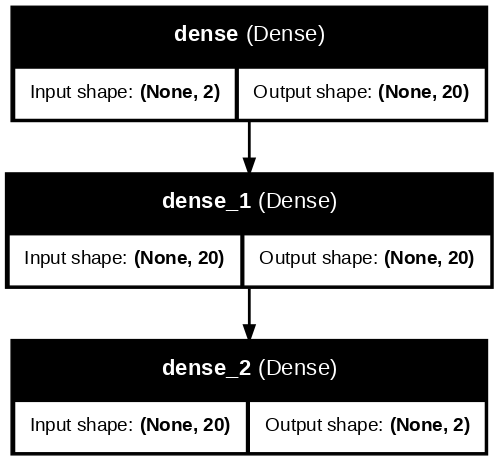

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True,dpi=100)

##### Prediction

In [ ]:
pred_ = model.predict(X_test)
pred =  np.where(pred_ >= 0.5, 0, 1)
pred = pred.astype(int)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Les résultats suivants sont enregistrés pour une analyse ultérieure.

In [ ]:
train_data_ = results[(echantillon,'PMC')]['train_data']
test_data_ = results[(echantillon, 'PMC')]['test_data'].copy()

test_data_['pred'] = pred
test_data_['d'] = test_data_['d'].astype(int)
test_data_['bien'] = (test_data_['d'] == test_data_['pred']).astype('category')

modele = 'KERAS'

results[(echantillon, modele)] = {
    "train_data": train_data_,
    "test_data": test_data_
    }

### Results

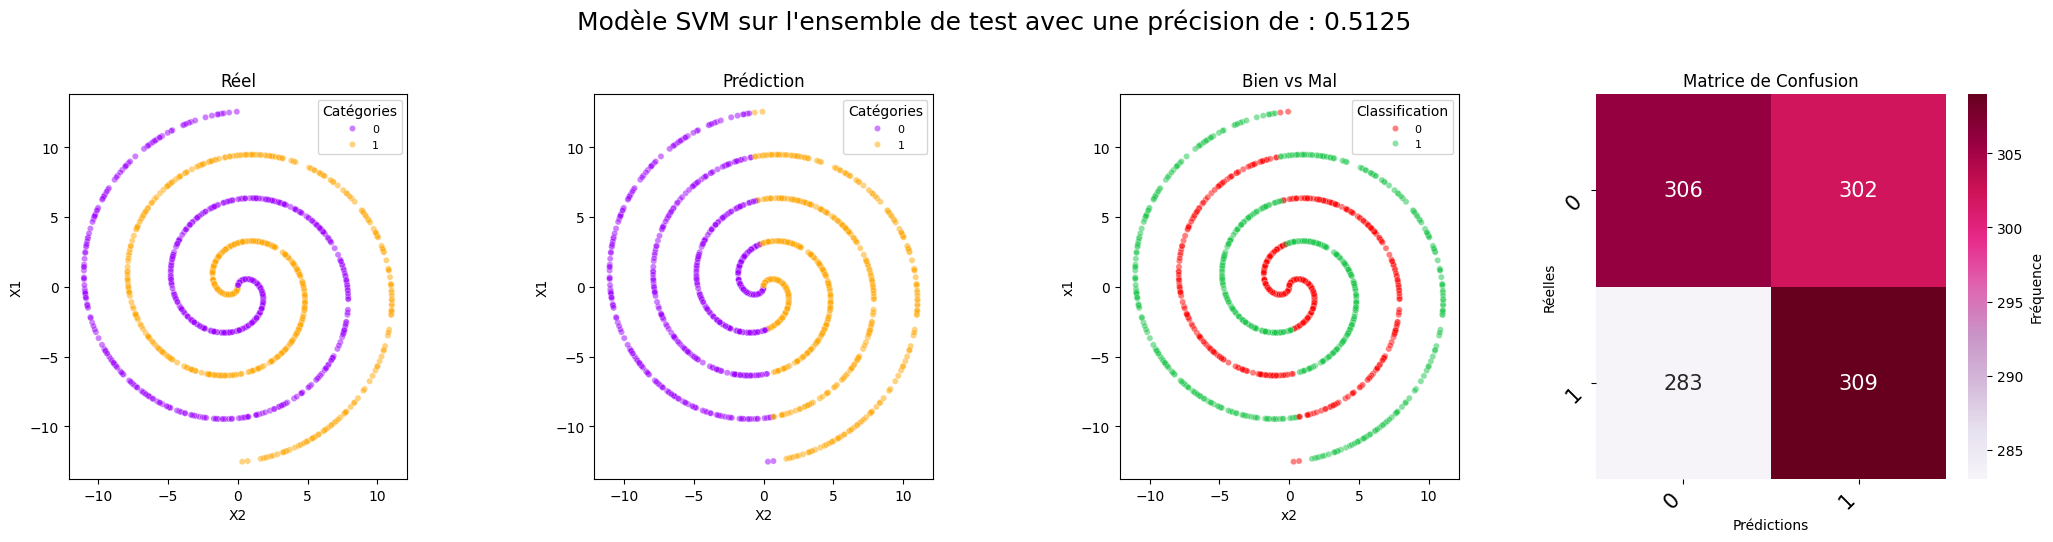

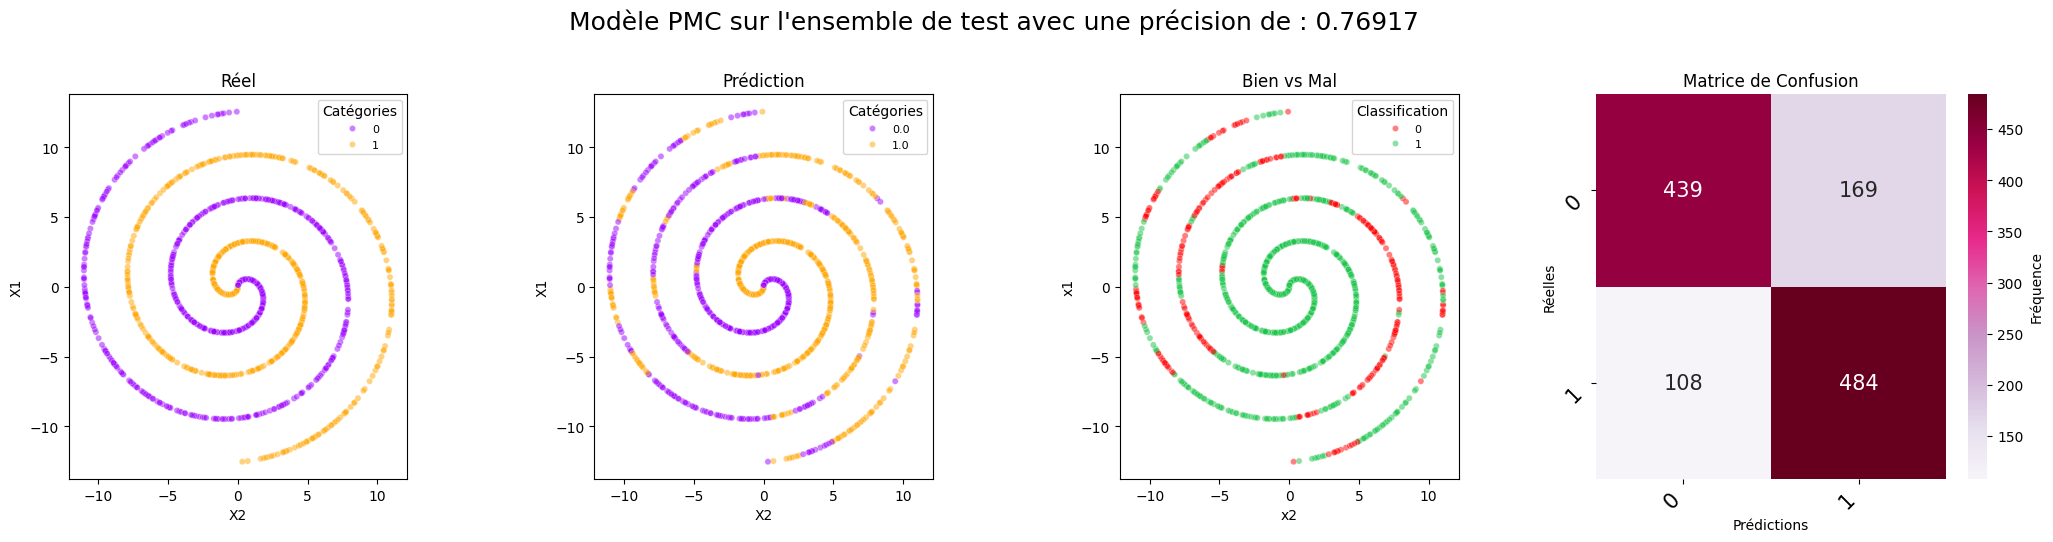

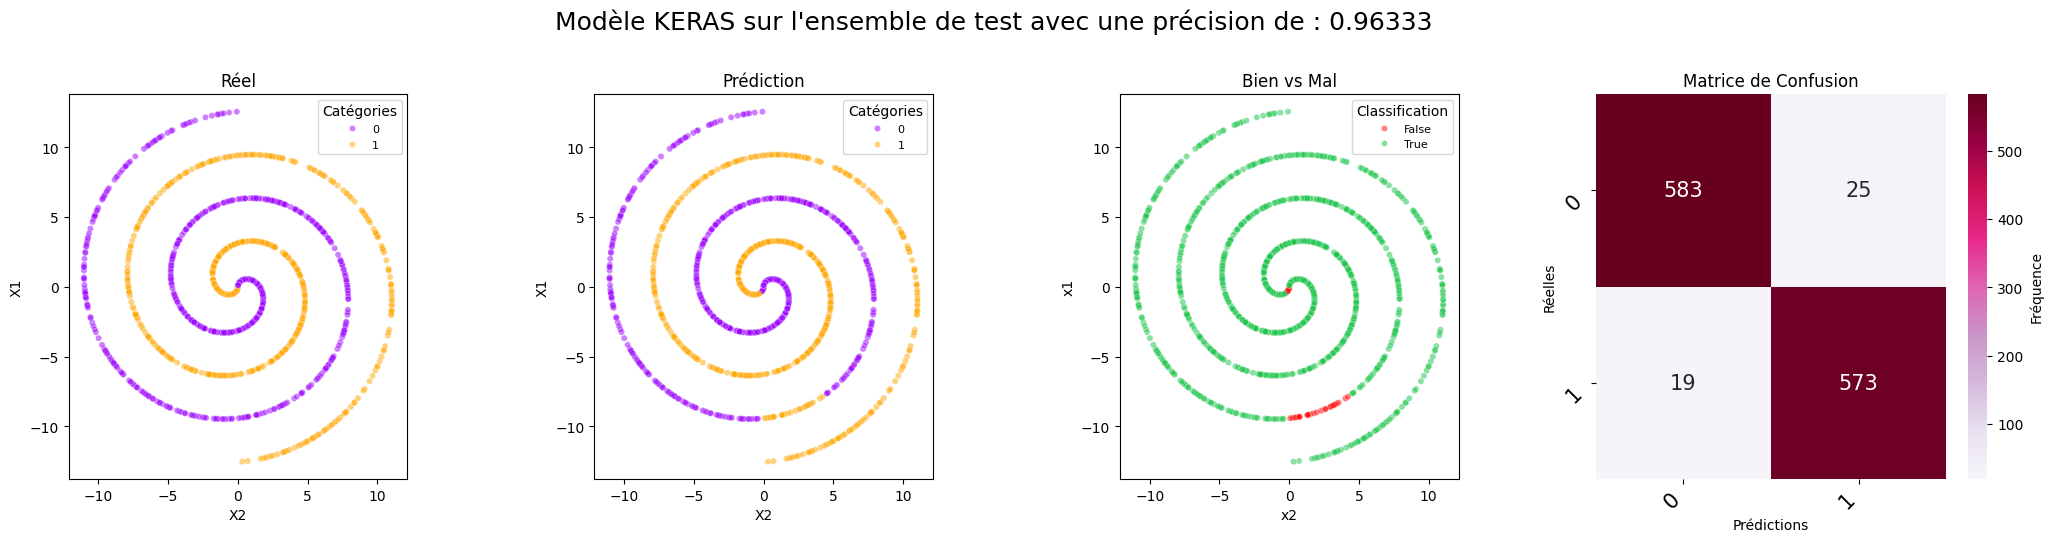

In [ ]:
afficher_graphiques(results[(echantillon,'SVM')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'SVM'
                    ,echantillon)


afficher_graphiques(results[(echantillon,'PMC')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'PMC'
                    ,echantillon)


afficher_graphiques(results[(echantillon,'KERAS')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'KERAS'
                    ,echantillon)


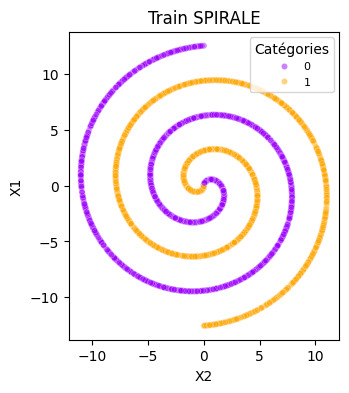

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
graphique_dispersion(results[(echantillon,'SVM')]['train_data']
                     , 'X2'
                     , 'X1'
                     , 'd'
                     ,ax
                     , titre=f'Train {echantillon}')


fichier_sortie = f"{path_graphs}/{echantillon}_train.png"
plt.savefig(fichier_sortie, format="png", bbox_inches="tight")
plt.show()

# Point 4

## Kohonen

### Implementation

In [ ]:
%%R
set.seed(1)

train_data_SOM <- train_data_GAUSS
test_data_SOM  <- test_data_GAUSS

# Normalisation des données
scaled_train <- scale(train_data_SOM[,c("X1", "X2")]
                      , center = TRUE
                      , scale = TRUE)


target_train <-train_data_SOM[,c("d")]

# Extraire les moyennes et les écarts-types
means <- attr(scaled_train, "scaled:center")
sds <- attr(scaled_train, "scaled:scale")
scaled_test <- scale(test_data_SOM[,c("X1", "X2")], center = means, scale = sds)
target_test  <-test_data_SOM[,c("d")]

# Choix du type de carte et de sa taille
som.grid <- somgrid(5, 3, topo="hexagonal", neighbourhood.fct="gaussian")

# Apprentissage
som.model <- som(scaled_train, grid =som.grid, rlen=1000, alpha=c(0.05,0.01)
                , keep.data = TRUE)

# Palette de couleur pour l'affichage des cartes
coolBlueHotRed <- function(t, alpha = 1) {rainbow(t, end=4/6, alpha=alpha)[t:1]}

#les vector reference
vect_ref = data.frame(som.model$codes)

In [ ]:
%%R
print(head(vect_ref))

            X1         X2
V1  1.31386103 -0.2416089
V2  0.79963545 -0.1159892
V3  0.02159229 -0.1652215
V4 -0.26457037 -0.9925703
V5 -0.64291546 -1.4174106
V6  1.30870007  0.2522160


#### Préparation des données

In [ ]:
# Train Normalisé et Vecteurs de Référence de Kohonen

vect_ref = ro.r['vect_ref']
vect_ref['d']="vect_ref"

scaled_train = pd.DataFrame(ro.r['scaled_train'])
echantillon = 'GAUSS'
scaled_train['d'] = results[(echantillon,'SVM')]['train_data']['d'].values
scaled_train.columns = ['X1', 'X2','d']

donnes = scaled_train


In [ ]:
target_train = ro.r['target_train']

target_train  = target_train.astype(int)
one_hot_encoding = {0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}
vector_target_train = np.array([one_hot_encoding[x] for x in target_train])

w_kohonen = vect_ref[['X1','X2']]
train = np.array(scaled_train[['X1','X2']])


### Graphiques de Kohonen

In [ ]:
r.assign("path_graphs", path_graphs)  #path in r

<rpy2.robjects.vectors.StrVector object at 0x7a77f8e41c40> [RTYPES.STRSXP]
R classes: ('character',)
['/content/drive/MyDrive/Maestria_Sorbonne/M2/2 s2...]

In [ ]:
%%R
set.seed(1)

# Position des vecteurs de référence sur la carte de Kohonen
filename <- paste(path_graphs, "kohonen_poids_par_dimension.png", sep = "/")
png(filename = filename, width = 800, height = 600)

par(oma = c(0, 0, 2, 0))
par(mfrow = c(1, 2))

df = data.frame(som.model$codes)

for (i in 1:2) {
  plot(som.model, type = "property", property = df[, i],
       palette.name = coolBlueHotRed,
       main = colnames(df)[i],
       cex = 0.8)
}

dev.off()


[1] 2


In [ ]:
%%R
# Répartition des points de données sur les vecteurs de référence
filename <- paste(path_graphs, "kohonen_comptage_des_neurones.png", sep = "/")
png(filename = filename, width = 800, height = 600)
plot(som.model, type="count", palette.name=coolBlueHotRed)
dev.off()


[1] 2


In [ ]:

def calculate_distances(point, w_kohonen):
    i = np.linalg.norm(w_kohonen - point, axis=1)
    r_=np.where(i == np.min(i))[0]
    return int(np.random.choice(r_))

colorfulness = [
    "#F89880", "#F67280", "#F62217", "#8F0B0B",
    "#4EE2EC", "#82CAFF", "#14A3C7", "#0000FF",
    "#347C17", "#54C571", "#E8A317", "#FFD700",
    "#9D00FF" , "#D891EF" , "#FF77FF"
    ]

distances = list(map(lambda point: calculate_distances(point, w_kohonen)
                    , donnes[['X1', 'X2']].values))

donnes['dd'] =  distances

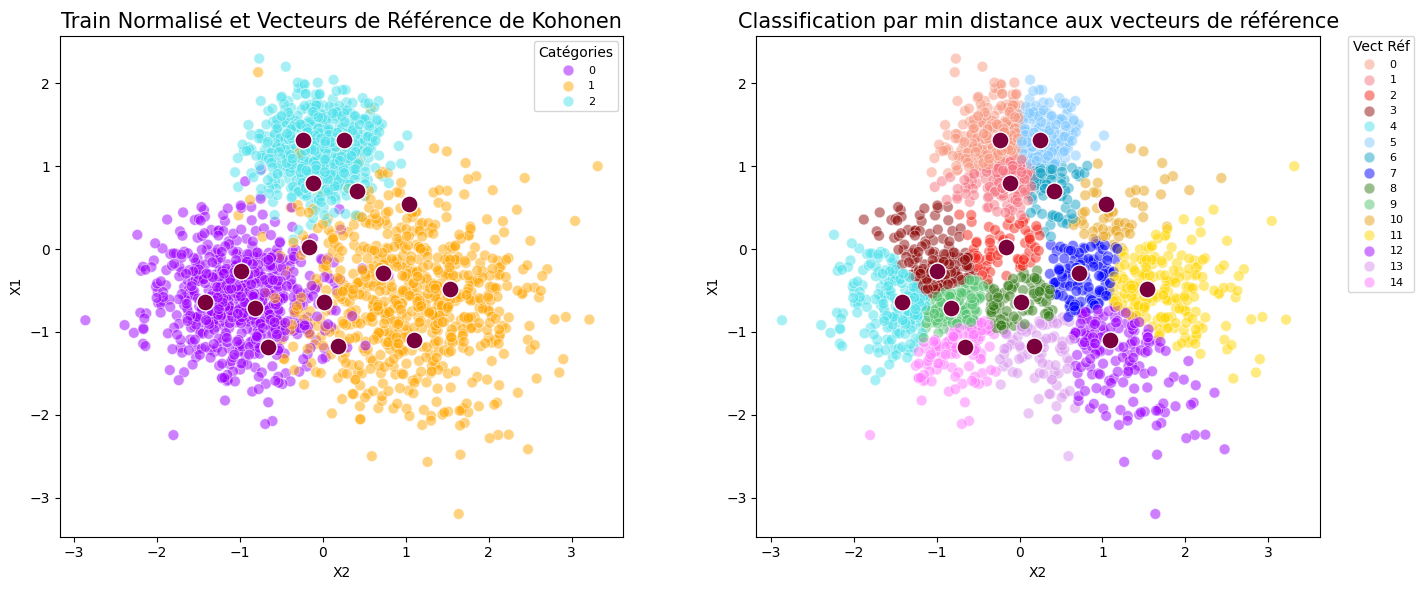

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Primer graph
sns.scatterplot(x='X2'
                , y='X1'
                , hue='d'
                , data=donnes
                , alpha=0.5
                , s=60
                , palette=colors_
                , ax=ax1)


sns.scatterplot(x='X2'
                , y='X1'
                , data=vect_ref
                , alpha=1
                , s=150
                , color=color_base
                , ax=ax1)

ax1.set_title("Train Normalisé et Vecteurs de Référence de Kohonen"
              ,fontsize=15)

ax1.set_xlabel("X2")
ax1.set_ylabel("X1")
ax1.set_aspect('equal', adjustable='box')
ax1.grid(False)
ax1.legend(title="Catégories", loc='upper right', fontsize=8
              , title_fontsize=10)

# Segundo graph
sns.scatterplot(x='X2'
                , y='X1'
                , hue='dd'
                , data=donnes
                , alpha=0.5
                , s=60
                , palette=colorfulness
                , ax=ax2)


sns.scatterplot(x='X2'
                , y='X1'
                , data=vect_ref
                , alpha=1
                , s=150
                , color=color_base
                , ax=ax2)

ax2.set_title("Classification par min distance aux vecteurs de référence"
              ,fontsize=15)
ax2.set_xlabel("X2")
ax2.set_ylabel("X1")
ax2.set_aspect('equal', adjustable='box')
ax2.grid(False)
ax2.legend(title="Vect Réf"
           , loc='upper left'
           , fontsize=8
           , title_fontsize=10
           , bbox_to_anchor=(1.05, 1)
           , borderaxespad=0.)

plt.tight_layout()

fichier_sortie = f"{path_graphs}/kohonen_vect_red_train.png"
plt.savefig(fichier_sortie, format="png", bbox_inches="tight")
plt.show()



## RBF

### Implementation

#### Fonctions pour entraîner un réseau

In [ ]:
## n -> # caractéristiques d’un individu ou d’un échantillon
## k -> # class
## m -> # neurones kohonen


def RBF_couche(x, w, sigma=1):
    """
    x (array(n,)) : Le vecteur d'entrée avec n caractéristiques.
    w (array(m,n)): Les centres de la fonction de base radiale,
                    où m est le nombre de vecteurs de référence.
    a (array(m,)) : activation gauss
    """
    #Fonction d'entrée : distance (ou Radial)/  couche cachée
    h = np.linalg.norm(x - w, axis=1)
    #Fonction d'activation : gaussienne / couche cachée
    a = np.exp(- (h ** 2) / (sigma ** 2))
    return a

def sortie_couche(a,w):
    """
    a (array(m,))     : Activation de la couche cachée, où
                        m est le nombre de neurones ou vecteurs de référence
    w (array(k, m))   : Matrice de poids, k représente le nombre de
                        classes ou classifications.
    return array(k,)  : foncion softmax
    """
    #Fonction d'entrée : affine / couche de sortie
    h = w@a
    #Fonction d'activation : Softmax / couche de sortie
    a = np.exp(h) / np.sum(np.exp(h), axis=0)
    return a

def arg_max_choice (i):
  r_=np.where(i == np.max(i))[0]  #predic. in R
  #pour le return, en cas d'égalité, sélectionner un indice aléatoirement
  return int(np.random.choice(r_))

def entropie_croisee_multiclasse(target, pred):
    # limiter les valeurs des probabilités entre epsilon et 1-epsilon
    epsilon = 1e-15
    pred = np.clip(pred, epsilon, 1 - epsilon)  # Empêche log(0) ou log(1)
    perte = -np.sum(target * np.log(pred), axis=0)
    return perte

def accuracy(target, pred):
  precision= np.sum(target == pred)/len(target)
  return round(precision, 3)

#### Algorithme

In [ ]:
sigma=1
lamb = 0.001
prev_w = np.random.rand(len(set(target_train)), len(w_kohonen)) #(#class,#koho)
epoch = 2

result_s = np.zeros([len(target_train)])
result_e = np.array([np.nan])
result_e_= np.zeros([len(target_train)])

for epoc in range(epoch):
  for i,x in enumerate(train): #x in (#caract.,)

    y = vector_target_train[i] #one hot encoder (#class,)

    # prediction
    a = RBF_couche(x,w_kohonen,sigma) #sorti couche_cachee fonc radial (#koho,)
    s = sortie_couche(a,prev_w ) #sorti de couche_sorti / softmax (#class,) /

    #apprendisage
    err_i = -y*(1-s) #err_i = -(dE/s_i)*f'(h(i)) i in (1,2,3) /(#class,)
    grad_entropy = (err_i[:, np.newaxis]*a) #(#class, #koho)
    #result_w : regle d'apprentissage delta / (#class,#koho)
    result_w = prev_w  - lamb*grad_entropy

    #loss
    e = entropie_croisee_multiclasse(y, s) #loss par chaque class (#class,)
    if prev_w is not None:
      result_e_[i] = e
    prev_w = result_w

    # decodage du one-hot
    result_s[i] = arg_max_choice(s) #un reel entre 0 et #class

  result_e = np.concatenate((result_e, result_e_))

Text(0.5, 1.0, "Évolution de l'entropie pendant l'entraînement avec 2 époques")

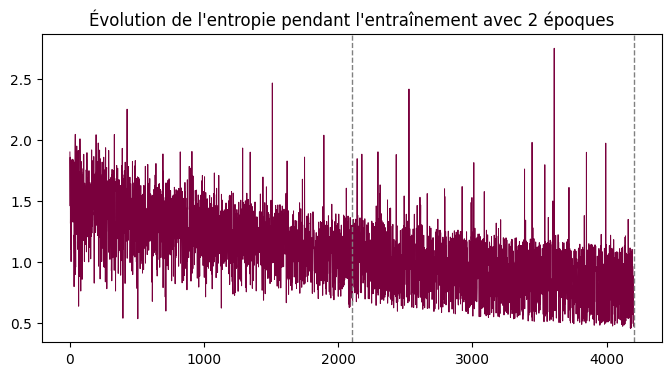

In [ ]:
iter_epoc = array = np.arange(1, epoch+1) * len(target_train)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(result_e, color= color_base,linewidth=0.7)

for i in iter_epoc:
  ax.axvline(x=i, color='gray', linestyle='--', linewidth=1)

plt.title(f"Évolution de l'entropie pendant l'entraînement avec {epoch} époques")

### Prediction

In [ ]:
scaled_test = ro.r['scaled_test']
target_test = ro.r['target_test']

target_test  = np.array(target_test, dtype=int)
vector_target_test = np.array([one_hot_encoding[x] for x in target_test])


In [ ]:
pred = np.zeros([len(target_test)])
for i in range(len(scaled_test)):
  x = scaled_test[i]
  y = vector_target_test[i]
  a = RBF_couche(x,w_kohonen,sigma)
  s = sortie_couche(a,result_w )
  pred[i] = int(np.argmax(s))


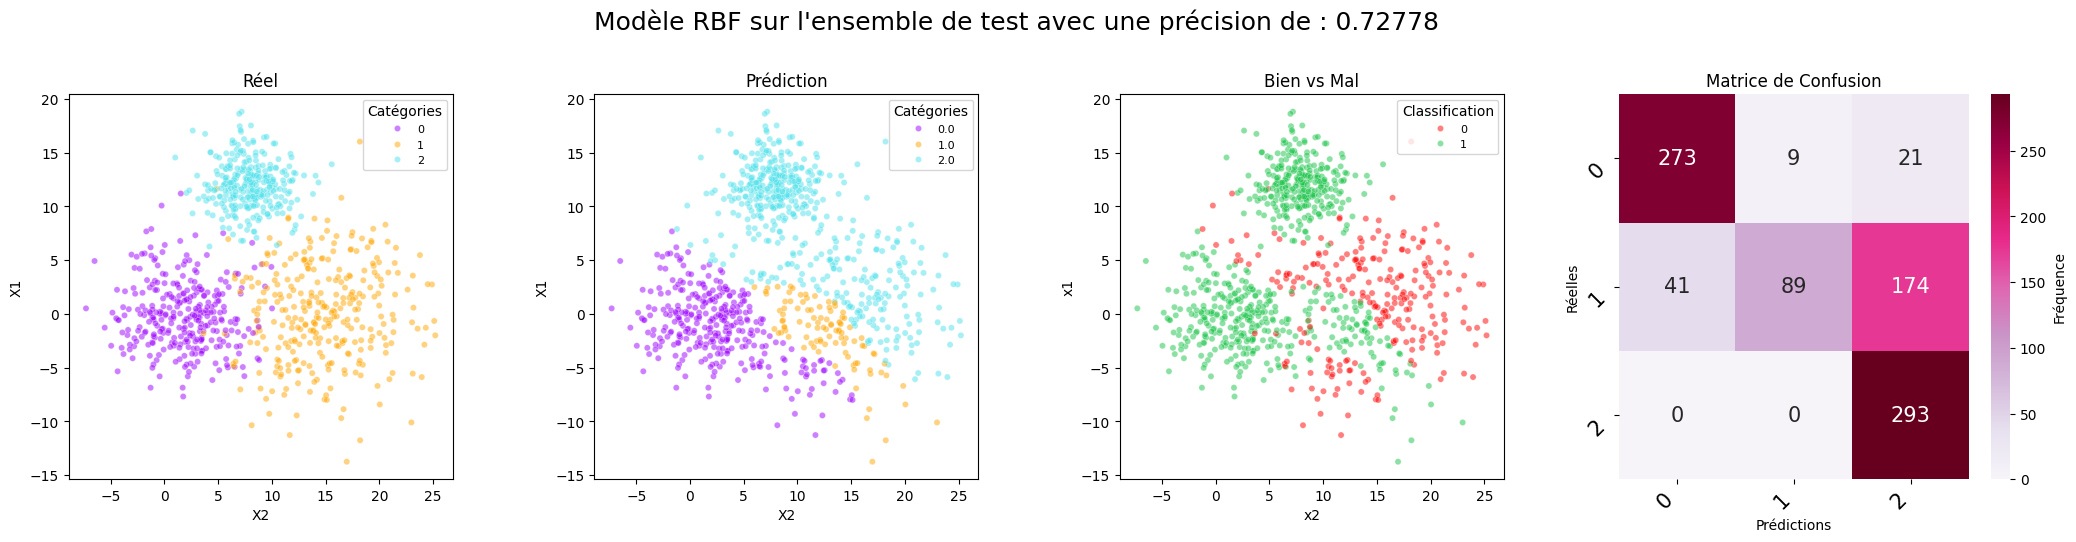

In [ ]:
train_data_ = results[(echantillon,'SVM')]['train_data']
test_data_ = results[(echantillon, 'SVM')]['test_data'].copy()

test_data_['pred'] = pred
test_data_['d'] = target_test
test_data_['bien'] = ((test_data_['d'] == test_data_['pred'])*1)
test_data_['bien'] = test_data_['bien'].astype('category')

modele = 'RBF'

results[(echantillon, modele)] = {
    "train_data": train_data_,
    "test_data": test_data_
    }

afficher_graphiques(results[(echantillon,'RBF')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'RBF'
                    ,echantillon)

# Point 6

## DNN

### Implementation

Dans la couche d'entrée, les données sont standardisées et la fonction d'entrée est appliquée pour calculer la distance aux vecteurs de référence de Kohonen.(point 4 - Kohonen)

Pour la première couche cachée, la fonction d'activation gaussienne doit être appliquée.

In [ ]:
nodes_premier_couche_cache = pd.DataFrame(
                                list(map(lambda x:
                                        RBF_couche(x, w_kohonen, sigma)
                                        , train)))

nodes_premier_couche_cache.head()

0         1         2         3         4         5         6   \
0  0.026718  0.132214  0.632629  0.704229  0.419031  0.016747  0.089359   
1  0.003025  0.026518  0.151301  0.017472  0.003569  0.007878  0.085546   
2  0.000051  0.000588  0.002886  0.000047  0.000004  0.000423  0.006501   
3  0.007531  0.045257  0.333200  0.690500  0.637247  0.003568  0.023887   
4  0.757518  0.932981  0.407997  0.071051  0.008147  0.847660  0.867828   

         7         8         9         10        11        12        13  \
0  0.215185  0.775383  0.877155  0.027944  0.016540  0.062676  0.449337   
1  0.749742  0.405513  0.042333  0.173094  0.652046  0.887770  0.468553   
2  0.112387  0.011392  0.000167  0.056823  0.656025  0.308497  0.018898   
3  0.080413  0.520013  0.981706  0.005640  0.004272  0.028594  0.361125   
4  0.156552  0.084790  0.028828  0.368186  0.018298  0.006525  0.012179   

         14  
0  0.667697  
1  0.062331  
2  0.000351  
3  0.872737  
4  0.006355

In [ ]:

X_train = nodes_premier_couche_cache
y_train = vector_target_train
# Construire le modèle de réseau neuronal
model = Sequential()

# Couche d'entrée (15 caractéristiques)
model.add(Input(shape=(15,)))

# Couches cachées
model.add(Dense(7, activation='relu'))

# Couche de sortie (3 clases)
model.add(Dense(3, activation='softmax'))

# Construire le modèle
model.compile(loss='categorical_crossentropy'
              , optimizer='adam'
              , metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train[:int(len(X_train)*0.8)],
          y_train[:int(len(y_train)*0.8)],
          epochs=50, batch_size=10,
          validation_data=(X_train[-int(len(X_train)*0.2):],
                           y_train[-int(len(y_train)*0.2):]),
          shuffle=False,
          verbose=0)

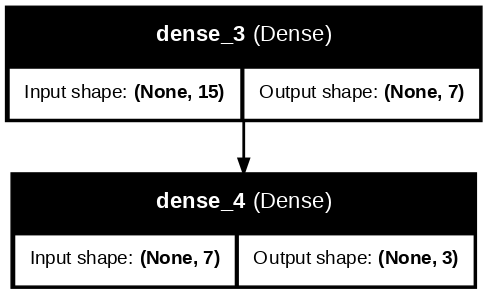

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True,dpi=100)

##### Prediction

In [ ]:
nodes_premier_couche_cache = pd.DataFrame(
                                list(map(lambda x:
                                          RBF_couche(x, w_kohonen, sigma)
                                          , scaled_test)))
X_test = nodes_premier_couche_cache
pred_ = model.predict(X_test)
pred =  np.array(list(map(arg_max_choice, pred_)))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


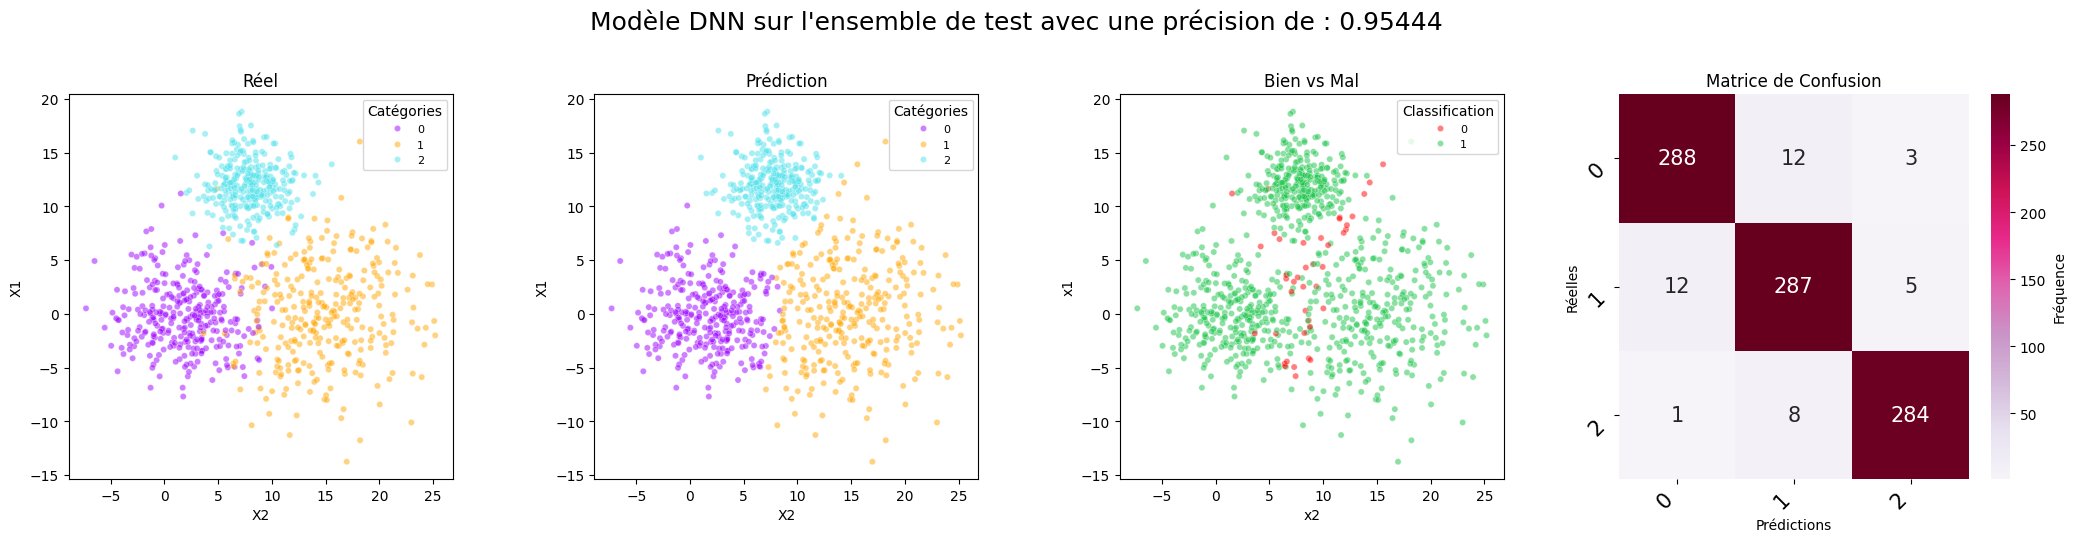

In [ ]:

train_data_ = results[(echantillon,'SVM')]['train_data']
test_data_ = results[(echantillon, 'SVM')]['test_data'].copy()

test_data_['pred'] = pred
test_data_['d'] = results[(echantillon, 'SVM')]['test_data']['d']
test_data_['bien'] = ((test_data_['d'].astype(int) == test_data_['pred'])*1)
test_data_['bien'] = test_data_['bien'].astype('category')



modele = 'DNN'

results[(echantillon, modele)] = {
    "train_data": train_data_,
    "test_data": test_data_
    }

afficher_graphiques(results[(echantillon,'DNN')]['test_data']
                    , 'X2'
                    , 'X1'
                    , 'd'
                    , 'pred'
                    , 'bien'
                    , 'DNN'
                    ,echantillon)